In [38]:
import imp
from sympy import im
from tqdm import tqdm
import time
import psutil

import numpy as np

# Dataset and preprocessing 
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from common_utils import compute_metrics, plot_fairness_impact
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Rewigh
from aif360.algorithms.preprocessing.reweighing import Reweighing

# Display and plot 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from tabulate import tabulate

# Models 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [60]:
# Select the model
model_used = "RF"  # SVC, RF

### Load dataset

In [61]:
dataset = load_preproc_data_german(['age'])
privileged_groups = [{'age': 1}]
unprivilege_groups = [{'age': 0}]

np.random.seed(42)

#### Split data
training, validation, testing data

In [62]:
og_train_set, og_vt_set = dataset.split([0.7], shuffle=True)
og_valid_set, og_test_set = og_vt_set.split([0.5], shuffle=True)

In [63]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(og_train_set.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(og_train_set.favorable_label, og_train_set.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(og_train_set.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(og_train_set.privileged_protected_attributes,
      og_train_set.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(og_train_set.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


### Reweighting

In [64]:
RW = Reweighing(unprivileged_groups=unprivilege_groups, privileged_groups=privileged_groups)

trans_train_set = RW.fit_transform(og_train_set)

In [65]:
### Testing 
assert np.abs(trans_train_set.instance_weights.sum() -
              og_train_set.instance_weights.sum()) < 1e-6

#### Mean Difference

In [66]:
og_diff_mean = BinaryLabelDatasetMetric(og_train_set, privileged_groups=privileged_groups, unprivileged_groups=unprivilege_groups)
og_diff_mean_value = og_diff_mean.mean_difference()
print("Original Dataset mean difference: %.4f" % og_diff_mean_value)


Original Dataset mean difference: -0.1452


In [67]:
trans_diff_mean = BinaryLabelDatasetMetric(trans_train_set, privileged_groups=privileged_groups, unprivileged_groups=unprivilege_groups)
trans_diff_mean_value = trans_diff_mean.mean_difference()
print("Transformed Dataset mean difference: %.4f" % trans_diff_mean_value)

Transformed Dataset mean difference: 0.0000


In [68]:
### Testing
assert np.abs(trans_diff_mean.mean_difference()) < 1e-6

### [Original] Train

Modeling

In [69]:

y_train = og_train_set.labels.ravel()

if model_used == "SVC":
    clf_model = LinearSVC()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(og_train_set.features)
if model_used == "RF":
    clf_model = RandomForestClassifier()
    X_train = og_train_set.features

# ==================================================
timer_str = time.time()
mem_str = psutil.Process().memory_info().rss / (1024 * 1024)

clf_model.fit(X_train, y_train, sample_weight=og_train_set.instance_weights)

timer_stp = time.time()
mem_stp = psutil.Process().memory_info().rss / (1024 * 1024)

og_train_time = timer_stp - timer_str
og_train_mem = mem_stp - mem_str

# ==================================================
# positive class index 
pos_ind = np.where(clf_model.classes_ == og_train_set.favorable_label)[0][0]


Score from validation and test set

In [70]:
og_valid_set_pred = og_valid_set.copy(deepcopy=True)
og_test_pred = og_test_set.copy(deepcopy=True)

y_valid = og_valid_set_pred.labels
y_test = og_test_pred.labels

if model_used == "SVC":
    X_valid = scaler.fit_transform(og_valid_set_pred.features)
    # predict on vaidation set
    og_valid_set_pred.scores = clf_model._predict_proba_lr(X_valid)[:, pos_ind].reshape(-1,1)

    X_test = scaler.fit_transform(og_test_pred.features)
    # predict on test set
    og_test_pred.scores = clf_model._predict_proba_lr(X_test)[:, pos_ind].reshape(-1,1)

if model_used == "RF":
    X_valid = og_valid_set_pred.features
    og_valid_set_pred.scores = clf_model.predict_proba(X_valid)[:, pos_ind].reshape(-1,1)

    X_test = og_test_pred.features
    og_test_pred.scores = clf_model.predict_proba(X_test)[:, pos_ind].reshape(-1,1)

Find optimal classification threshold 

In [71]:
# Find optimal threshold based on balanced accuracy
num_thresh = 100    # 0.00 - 1.00
ba_acc = np.zeros(num_thresh)   # balance accuracy for each threshold
recall_acc = np.zeros(num_thresh)   # recall for each threshold
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)  # search space 

for idx, threshold in enumerate(class_thresh_arr):
    # set labels if probability > threshold 
    fav_inds = og_valid_set_pred.scores > threshold
    og_valid_set_pred.labels[fav_inds] = og_valid_set_pred.favorable_label
    og_valid_set_pred.labels[~fav_inds] = og_valid_set_pred.unfavorable_label

    # classified metric 
    og_valid_class_met = ClassificationMetric(og_valid_set, og_valid_set_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivilege_groups)

    ba_acc[idx] = 0.5 * (og_valid_class_met.true_positive_rate() + og_valid_class_met.true_negative_rate())

    recall_acc[idx] = og_valid_class_met.recall()

best_idx_acc = np.where(ba_acc == np.max(ba_acc))[0][0]
best_idx_recall = np.where(recall_acc == np.max(recall_acc))[0][0]

best_class_thresh_acc = class_thresh_arr[best_idx_acc]
best_class_thresh_recall = class_thresh_arr[best_idx_acc]

print("Best balanced accuracy (No reweighting) = %.4f" % np.max(ba_acc))
print("Best recall (no reweighting) = %.4f" % np.max(recall_acc))

print("Optimal threshold based on accuracy = %.4f" % best_class_thresh_acc)
print("Optimal threshold based on recall = %.4f " % best_class_thresh_recall)


Best balanced accuracy (No reweighting) = 0.7148
Best recall (no reweighting) = 1.0000
Optimal threshold based on accuracy = 0.6930
Optimal threshold based on recall = 0.6930 


### [Original] Predict testing set 

In [72]:
from dis import dis


display(Markdown("#### Prediction from original data"))
# performance metrics
og_bal_acc = []
og_precision = []
og_recall = []
og_f1 = []

# fairness metrics
og_dis_imp = []
og_avg_odds_diff = []

thresh_idx = 0   # index of the best threshold

print("Theshold used = %.4f" % best_class_thresh_acc)\

for idx, thresh in tqdm(enumerate(class_thresh_arr)):
    if thresh == best_class_thresh_acc:
        disp = True
        thresh_idx = idx
    else:
        disp = False

    fav_inds = og_test_pred.scores > thresh
    og_test_pred.labels[fav_inds] = og_test_pred.favorable_label
    og_test_pred.labels[~fav_inds] = og_test_pred.unfavorable_label

    og_test_class_met = compute_metrics(og_test_set, og_test_pred, unprivilege_groups, privileged_groups, disp=disp)

    # performance
    og_bal_acc.append(og_test_class_met["Balanced accuracy"])
    og_precision.append(og_test_class_met["Precision"])
    og_recall.append(og_test_class_met["Recall"])
    og_f1.append(og_test_class_met["F1"])
    
    # fairness
    og_dis_imp.append(og_test_class_met["Disparate impact"])
    og_avg_odds_diff.append(og_test_class_met["Average odds difference"])

#### Prediction from original data

Theshold used = 0.6930


100it [00:00, 1052.64it/s]

Balanced accuracy = 0.6158
Precision = 0.8103
Recall = 0.4608
F1 = 0.5875
Disparate impact = 0.4298
Average odds difference = -0.2059


#### [Original] Disparate Impact 

Best balance accuracy: 0.6158
abs(1-disparate impact): 0.5702


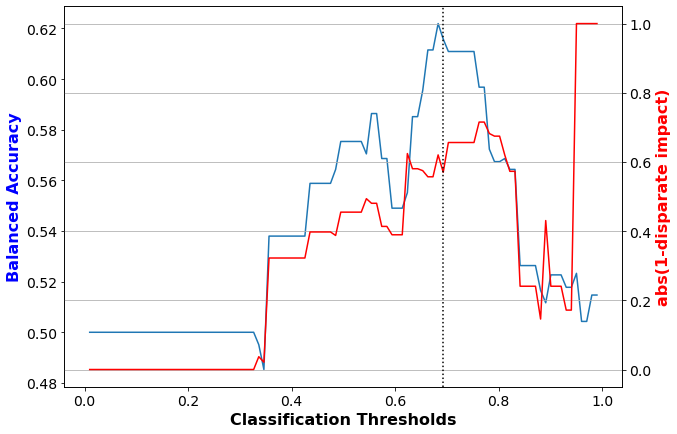

In [73]:
plot_fairness_impact(class_thresh_arr, best_class_thresh_acc, thresh_idx, og_bal_acc, og_dis_imp, "DI")

#### [Original] Average odds difference

Best balance accuracy: 0.6158
Avg. odds diff: -0.2059


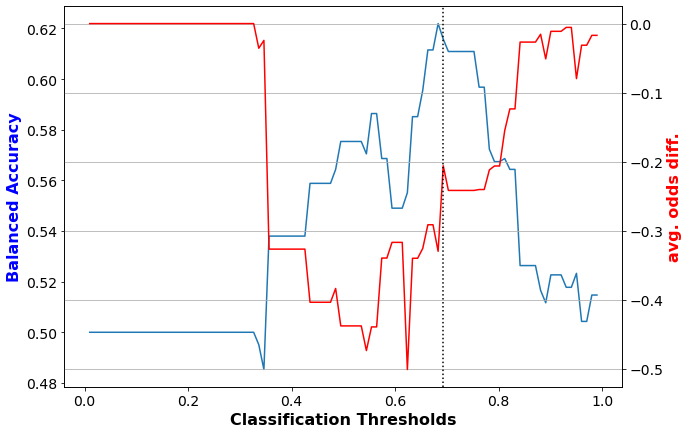

In [74]:
plot_fairness_impact(class_thresh_arr, best_class_thresh_acc, thresh_idx, og_bal_acc, og_avg_odds_diff, "AOD")

### [Transf] Train

In [75]:
y_train = trans_train_set.labels.ravel()

if model_used == "SVC":
    clf_model = LinearSVC()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(trans_train_set.features)
if model_used == "RF":
    clf_model = RandomForestClassifier()
    X_train = trans_train_set.features

timer_str = time.time()
mem_str = psutil.Process().memory_info().rss / (1024 * 1024)

clf_model.fit(X_train, y_train, sample_weight=trans_train_set.instance_weights)

timer_stp = time.time()
mem_stp = psutil.Process().memory_info().rss / (1024 * 1024)

trans_train_time = timer_stp - timer_str
trans_train_mem = mem_stp - mem_str


Score from trans test set

In [76]:
trans_test_pred = og_test_set.copy(deepcopy=True)
y_test = trans_test_pred.labels

if model_used == "SVC":
    X_test = scaler.fit_transform(trans_test_pred.features)
    trans_test_pred.scores = clf_model._predict_proba_lr(X_test)[:, pos_ind].reshape(-1,1)
if model_used == "RF":
    X_test = trans_test_pred.features
    trans_test_pred.scores = clf_model.predict_proba(X_test)[:, pos_ind].reshape(-1,1)

### [Transf] Predict test set

In [77]:
display(Markdown("#### Prediction from transformed data"))
# performance metrics
trans_bal_acc = []
trans_precision = []
trans_recall = []
trans_f1 = []

# fairness metrics
trans_dis_imp = []
trans_avg_odds_diff = []

trans_thresh_idx = 0   # index of the best threshold

print("Theshold used = %.4f" % best_class_thresh_acc)\

for idx, thresh in tqdm(enumerate(class_thresh_arr)):
    if thresh == best_class_thresh_acc:
        disp = True
        trans_thresh_idx = idx
    else:
        disp = False

    fav_inds = trans_test_pred.scores > thresh
    trans_test_pred.labels[fav_inds] = trans_test_pred.favorable_label
    trans_test_pred.labels[~fav_inds] = trans_test_pred.unfavorable_label

    trans_test_class_met = compute_metrics(
        og_test_set, trans_test_pred, unprivilege_groups, privileged_groups, disp=disp)

    # performance
    trans_bal_acc.append(trans_test_class_met["Balanced accuracy"])
    trans_precision.append(trans_test_class_met["Precision"])
    trans_recall.append(trans_test_class_met["Recall"])
    trans_f1.append(trans_test_class_met["F1"])
    
    # fairness
    trans_dis_imp.append(trans_test_class_met["Disparate impact"])
    trans_avg_odds_diff.append(trans_test_class_met["Average odds difference"])


#### Prediction from transformed data

Theshold used = 0.6930


100it [00:00, 1020.43it/s]

Balanced accuracy = 0.6097
Precision = 0.7937
Recall = 0.4902
F1 = 0.6061
Disparate impact = 0.8595
Average odds difference = -0.0218


#### [Transf] Disparate Impact 

Best balance accuracy: 0.6097
abs(1-disparate impact): 0.1405


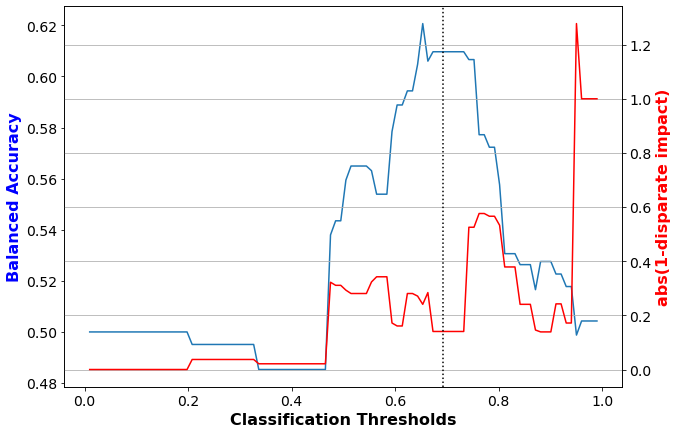

In [78]:
plot_fairness_impact(class_thresh_arr, best_class_thresh_acc,
                      thresh_idx, trans_bal_acc, trans_dis_imp, "DI")


#### [Transf] Average odds difference

Best balance accuracy: 0.6097
Avg. odds diff: -0.0218


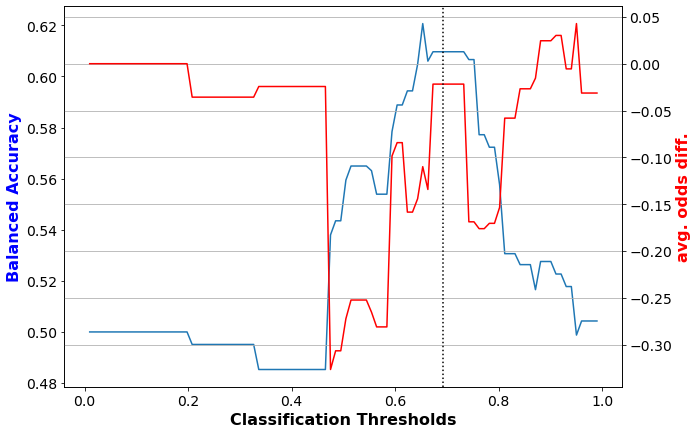

In [79]:
plot_fairness_impact(class_thresh_arr, best_class_thresh_acc,
                      thresh_idx, trans_bal_acc, trans_avg_odds_diff, "AOD")


## Summary

In [82]:
display(Markdown("## Summary"))
display(Markdown("#### Dataset Mean Difference before and after Reweighting"))
print("Mean Differece Before reweight: %.4f" % og_diff_mean_value)
print("Mean Differece After reweight: %.4f" % trans_diff_mean_value)

performance_table = {
    'Reweighting': ["Before", "After"],
    'Accuracy': [og_bal_acc[thresh_idx], trans_bal_acc[thresh_idx]],
    'Precision' : [og_precision[thresh_idx], trans_precision[thresh_idx]],
    'Recall' : [og_recall[thresh_idx], trans_recall[thresh_idx]],
    'F1' : [og_f1[thresh_idx], trans_f1[thresh_idx]],
    'Time' : [og_train_time, trans_train_time],
    'Memory' : [og_train_mem, trans_train_mem]
}

print(f'\nModel used: {model_used}')
display(Markdown("#### Performance metrics"))
print(tabulate(performance_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))

fairness_table = {
    'Reweighing' : ["Before", "After"],
    'Recall' : [og_recall[thresh_idx], trans_recall[thresh_idx]],
    'Disparate Impact': [og_dis_imp[thresh_idx], trans_dis_imp[thresh_idx]],
    'Average Odds Difference' : [og_avg_odds_diff[thresh_idx], trans_avg_odds_diff[thresh_idx]]
}

display(Markdown("#### Fairness metrics"))
print(tabulate(fairness_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))
display(Markdown("##### Noted for the classification to be fair"))
print("Disparate impact: higher is better.\nAverage odds difference: must be close to zero.")


## Summary

#### Dataset Mean Difference before and after Reweighting

Mean Differece Before reweight: -0.1452
Mean Differece After reweight: 0.0000

Model used: RF


#### Performance metrics

╒═══════════════╤════════════╤═════════════╤══════════╤════════╤════════╤══════════╕
│ Reweighting   │   Accuracy │   Precision │   Recall │     F1 │   Time │   Memory │
╞═══════════════╪════════════╪═════════════╪══════════╪════════╪════════╪══════════╡
│ Before        │     0.6158 │      0.8103 │   0.4608 │ 0.5875 │ 0.1400 │   0.2695 │
├───────────────┼────────────┼─────────────┼──────────┼────────┼────────┼──────────┤
│ After         │     0.6097 │      0.7937 │   0.4902 │ 0.6061 │ 0.1280 │   0.0391 │
╘═══════════════╧════════════╧═════════════╧══════════╧════════╧════════╧══════════╛


#### Fairness metrics

╒══════════════╤══════════╤════════════════════╤═══════════════════════════╕
│ Reweighing   │   Recall │   Disparate Impact │   Average Odds Difference │
╞══════════════╪══════════╪════════════════════╪═══════════════════════════╡
│ Before       │   0.4608 │             0.4298 │                   -0.2059 │
├──────────────┼──────────┼────────────────────┼───────────────────────────┤
│ After        │   0.4902 │             0.8595 │                   -0.0218 │
╘══════════════╧══════════╧════════════════════╧═══════════════════════════╛


##### Noted for the classification to be fair

Disparate impact: higher is better.
Average odds difference: must be close to zero.
